# Setup

In [ ]:
! pip install treelib

In [ ]:
import random as rnd
import itertools
from sympy import isprime
from treelib import Node, Tree
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
samples = 10000
games = []

# Sampling

In [ ]:
for i in range(samples):
    cards = []
    for j in range(2,26):
        cards.append(j)
    pl1 = []
    pl2 = []
    for j in range(12):
        c1 = rnd.choice(cards)
        pl1.append(c1)
        cards.remove(c1)
        c2 = rnd.choice(cards)
        pl2.append(c2)
        cards.remove(c2)
    games.append([pl1, pl2])

In [ ]:
for i in range(len(games)):
  print(games[i])

Output streaming troncato alle ultime 5000 righe.
[[5, 18, 21, 20, 19, 4, 17, 8, 22, 7, 25, 14], [24, 6, 10, 16, 11, 23, 12, 9, 13, 3, 15, 2]]
[[3, 13, 6, 18, 15, 24, 9, 21, 12, 16, 20, 14], [11, 17, 22, 23, 19, 2, 8, 25, 5, 10, 4, 7]]
[[10, 4, 23, 17, 14, 12, 24, 19, 20, 6, 15, 22], [25, 18, 2, 21, 7, 11, 13, 3, 16, 9, 8, 5]]
[[5, 17, 15, 19, 13, 11, 14, 3, 23, 12, 2, 9], [20, 6, 25, 22, 21, 8, 16, 4, 10, 7, 18, 24]]
[[20, 4, 6, 21, 25, 2, 5, 10, 11, 12, 15, 8], [7, 17, 18, 9, 16, 13, 19, 24, 3, 14, 23, 22]]
[[14, 10, 24, 21, 17, 18, 19, 15, 9, 11, 12, 16], [23, 7, 25, 20, 6, 22, 8, 4, 5, 13, 3, 2]]
[[4, 16, 24, 6, 20, 14, 22, 11, 2, 7, 18, 3], [10, 23, 21, 12, 25, 8, 13, 5, 9, 15, 19, 17]]
[[18, 4, 17, 8, 14, 11, 15, 22, 7, 21, 9, 13], [5, 10, 24, 20, 25, 23, 19, 16, 2, 3, 12, 6]]
[[8, 10, 5, 21, 4, 18, 25, 14, 17, 22, 9, 2], [19, 16, 11, 20, 6, 12, 7, 15, 13, 3, 23, 24]]
[[22, 24, 5, 10, 25, 21, 14, 11, 2, 6, 23, 15], [18, 4, 20, 3, 13, 17, 8, 12, 7, 19, 9, 16]]
[[6, 21, 22, 23, 9, 

# Strategies
* Simple dumb ones, like random cards, max value cards etc
* Advanced strategies leveraging zero-sum modelling that take inspiration from security and minimax (significant approx. from their real counterparts)

* Backward induction is infeasible!

In [ ]:
def random_strat(player, opp):
  '''
  returns a random card from the player's pile
  '''
  if  len(player.cards) == 0:
    raise Exception("Sorry, empty list given")

  my_cards_list = player.cards
  rnd_index = rnd.randint(0, len(my_cards_list) - 1)
  return my_cards_list.pop(rnd_index)

def max_strat(player, opp):
  '''
  returns the card with the highest value from the player's pile
  '''
  if  len(player.cards) == 0:
    raise Exception("Sorry, empty list given")
  my_cards_list = player.cards
  max_card = max(my_cards_list)
  my_cards_list.remove(max_card)
  return max_card

def min_strat(player, opp):
  '''
  returns the card with the lowest value from the player's pile
  '''
  if  len(player.cards) == 0:
    raise Exception("Sorry, empty list given")
  my_cards_list = player.cards
  min_card = min(my_cards_list)
  my_cards_list.remove(min_card)
  return min_card

def prime_first_strat(player, opp):
  '''
  returns the first prime number it finds, if any, otherwise it returns the first composite number (random prime/composite play)
  '''
  if  len(player.cards) == 0:
    raise Exception("Sorry, empty list given")
  my_cards_list = player.cards
  for card in my_cards_list:
        if isprime(card):
            my_cards_list.remove(card)
            return card
  return my_cards_list.pop(0)

def composite_first_strat(player, opp):
  '''
  returns the first composite number it finds, if any, otherwise it returns the first prime number (random prime/composite play)
  '''
  if  len(player.cards) == 0:
    raise Exception("Sorry, empty list given")
  my_cards_list = player.cards
  for card in my_cards_list:
        if not isprime(card):
            my_cards_list.remove(card)
            return card
  return my_cards_list.pop(0)

def max_value_strategy(player, opp):
  '''
  returns the card that leads to the highest score
  '''
  if  len(player.cards) == 0:
    raise Exception("Sorry, empty list given")

  max_index = np.argmax([compute_score(card, get_other_cards(card, player, opp)) for card in player.cards])
  return player.cards.pop(max_index)

def security_strategy(player, opp):
  '''
  returns the card that is selected by the security strategy
  '''
  if len(opp.cards) == 0:
    return max_value_strategy(player, opp)
  outcomes_m = get_outcomes_matrix(player, opp)
  temp_mins = []
  for outs in outcomes_m:
    temp_mins.append(min([p[0] for p in outs]))
  best_index = np.argmax(temp_mins)
  return player.cards.pop(best_index)

def minimax_strategy(player, opp):
  '''
  returns the card that is selected by the minimax strategy
  '''
  if len(opp.cards) == 0:
    return max_value_strategy(player, opp)
  outcomes_m = get_outcomes_matrix(player, opp)
  temp_max_indicies = []
  temp_max = []
  for i in range(len(opp.cards)):
    temp = []
    for outs in outcomes_m:
      temp.append(outs[i][0])
    temp_max_indicies.append(np.argmax(temp))
    temp_max.append(max(temp))
  best_index = temp_max_indicies[np.argmin(temp_max)]
  return player.cards.pop(best_index)

def get_outcomes_matrix(p1, p2):
  m = []
  for card1 in p1.cards:
    cards_to_check = get_other_cards(card1, p1, p2)
    score = compute_score(card1, cards_to_check)
    m.append([(score, -1*score) for card in p2.cards])

    for card2 in p2.cards:
      cards_to_check = get_other_cards(card2, p2, p1)
      old_card = p1.prime_slot if isprime(card1) else p1.composite_slot
      if old_card != 0:
        cards_to_check.remove(old_card)
      cards_to_check.append(card1)

      score = compute_score(card2, cards_to_check)
      for i in range(len(m[-1])):
        m[-1][i] = (m[-1][i][0] - score, score + m[-1][i][1])
  return m

In [ ]:
class Player:
  def __init__(self, cards_list, strat):  #strat is one of the above defined strategy functions
    self.cards = cards_list
    self.strat = strat
    self.score = 0
    self.prime_slot = 0
    self.composite_slot = 0

  def play_a_card(self, opp):
    if not self.cards:
      raise Exception("Sorry, empty list of cards")

    card_value = self.strat(self, opp) # strat also removes the card

    if isprime(card_value):
      self.prime_slot = card_value
    else:
      self.composite_slot = card_value

    return card_value

def check_operation(played_card, cards_to_check):
  op_list = []
  if len(cards_to_check) < 2:
    return op_list
  for p in list(itertools.combinations(cards_to_check, 2)):
    desc = ""
    if isprime(p[0]):
      desc += "p"
    else:
      desc += "c"
    if isprime(p[1]):
      desc += "p"
    else:
      desc += "c"
    if played_card == p[0] + p[1] or played_card == p[0] * p[1] or played_card == p[0] - p[1] or played_card == p[1] - p[0] or played_card == p[0] / p[1] or played_card == p[1] / p[0]:
      op_list.append(desc)
  return op_list

def compute_score(card_played, others):
  score = 0
  op_list = check_operation(card_played, others)
  if isprime(card_played): # card is prime
    score = 2
    if 'pp' in op_list:
      return 6 # max score
  else: # card is composite
    score = 1
  if 'cp' in op_list or 'pc' in op_list:
    score += 3
  elif 'cc' in op_list:
    score += 2
  return score

def get_other_cards(card_played, player, opponent):
  # fill the list of cards to check if they can perform an operation with card_played
  cards_to_check = []
  if isprime(card_played):
    if not player.composite_slot == 0:
      cards_to_check.append(player.composite_slot)
  else:
    if not player.prime_slot == 0:
      cards_to_check.append(player.prime_slot)

  if not opponent.prime_slot == 0:
    cards_to_check.append(opponent.prime_slot)
  if not opponent.composite_slot == 0:
    cards_to_check.append(opponent.composite_slot)
  return cards_to_check

# Game

In [ ]:
class Game:
  def __init__(self,cards, p1_strat, p2_strat):
    self.p1 = Player(cards[0], p1_strat)
    self.p2 = Player(cards[1], p2_strat)
    self.starts1 = 1 if 2 in cards[0] else 0

  def get_players_order(self, turn):
    if turn % 2 == 0:
      if self.starts1:
        return self.p1, self.p2
      else:
        return self.p2, self.p1
    elif self.starts1:
      return self.p2, self.p1
    else:
      return self.p1, self.p2

  def start_the_game(self):
    for i in range(24):
      print(f'TURN {i}')
      print(f"P1 SCORE {self.p1.score}".ljust(15) + f"P2 SCORE {self.p2.score}")

      current_player, opponent_player = self.get_players_order(i)

      #current player plays a card according to his/her strategy
      card_played = current_player.play_a_card(opponent_player) # this also updates the piles
      print("Card played " + str(card_played))

      print(f"{'PLAYER 1':<15}{'PLAYER 2'}")
      print()
      print(f"P [{self.p1.prime_slot}]".ljust(15) + f"P [{self.p2.prime_slot}]")
      print(f"C [{self.p1.composite_slot}]".ljust(15) + f"C [{self.p2.composite_slot}]")

      print(f"P1 hand's {self.p1.cards}")
      print(f"P2 hand's {self.p2.cards}")

      cards_to_check = get_other_cards(card_played, current_player, opponent_player)
      current_player.score += compute_score(card_played, cards_to_check)

      print(f'New score: {current_player.score}')
      print("----------------------------")

    # return the game scores
    print("GAME CONCLUDED")
    print(f"P1 SCORE {self.p1.score}".ljust(15) + f"P2 SCORE {self.p2.score}")
    if self.p1.score > self.p2.score:
      print("P1 wins!")
      return 1, (self.p1.score, self.p2.score)
    elif self.p1.score < self.p2.score:
      print("P2 wins!")
      return -1, (self.p1.score, self.p2.score)
    else:
      print("IT'S A TIE!!!")
    return 0, (self.p1.score, self.p2.score)

# Simulations & Statistical analysis
Here we run the simulations of the game with different combinations of strategies

In [ ]:
#EXAMPLE
print(games[5])
game = Game(deepcopy(games[5]), max_strat, max_strat) # deepcopy is needed for reproducibility of results
game.start_the_game()

[[21, 3, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19], [18, 23, 17, 24, 13, 15, 6, 2, 12, 4, 8, 22]]
TURN 0
P1 SCORE 0     P2 SCORE 0
Card played 24
PLAYER 1       PLAYER 2

P [0]          P [0]
C [0]          C [24]
P1 hand's [21, 3, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19]
P2 hand's [18, 23, 17, 13, 15, 6, 2, 12, 4, 8, 22]
New score: 1
----------------------------
TURN 1
P1 SCORE 0     P2 SCORE 1
Card played 25
PLAYER 1       PLAYER 2

P [0]          P [0]
C [25]         C [24]
P1 hand's [21, 3, 5, 7, 20, 10, 9, 14, 16, 11, 19]
P2 hand's [18, 23, 17, 13, 15, 6, 2, 12, 4, 8, 22]
New score: 1
----------------------------
TURN 2
P1 SCORE 1     P2 SCORE 1
Card played 23
PLAYER 1       PLAYER 2

P [0]          P [23]
C [25]         C [24]
P1 hand's [21, 3, 5, 7, 20, 10, 9, 14, 16, 11, 19]
P2 hand's [18, 17, 13, 15, 6, 2, 12, 4, 8, 22]
New score: 3
----------------------------
TURN 3
P1 SCORE 1     P2 SCORE 3
Card played 21
PLAYER 1       PLAYER 2

P [0]          P [23]
C [21]         C [24]
P1 hand's

(1, (22, 19))

In [ ]:
print(games[5])
game = Game(deepcopy(games[5]), security_strategy, max_strat) # deepcopy is needed for reproducibility of results
game.start_the_game()

[[21, 3, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19], [18, 23, 17, 24, 13, 15, 6, 2, 12, 4, 8, 22]]
TURN 0
P1 SCORE 0     P2 SCORE 0
Card played 24
PLAYER 1       PLAYER 2

P [0]          P [0]
C [0]          C [24]
P1 hand's [21, 3, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19]
P2 hand's [18, 23, 17, 13, 15, 6, 2, 12, 4, 8, 22]
New score: 1
----------------------------
TURN 1
P1 SCORE 0     P2 SCORE 1
Card played 3
PLAYER 1       PLAYER 2

P [3]          P [0]
C [0]          C [24]
P1 hand's [21, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19]
P2 hand's [18, 23, 17, 13, 15, 6, 2, 12, 4, 8, 22]
New score: 2
----------------------------
TURN 2
P1 SCORE 2     P2 SCORE 1
Card played 23
PLAYER 1       PLAYER 2

P [3]          P [23]
C [0]          C [24]
P1 hand's [21, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19]
P2 hand's [18, 17, 13, 15, 6, 2, 12, 4, 8, 22]
New score: 3
----------------------------
TURN 3
P1 SCORE 2     P2 SCORE 3
Card played 5
PLAYER 1       PLAYER 2

P [5]          P [23]
C [0]          C [24]
P1 hand's

(1, (26, 16))

In [ ]:
print(games[5])
game = Game(deepcopy(games[5]), minimax_strategy, max_strat) # deepcopy is needed for reproducibility of results
game.start_the_game()

[[21, 3, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19], [18, 23, 17, 24, 13, 15, 6, 2, 12, 4, 8, 22]]
TURN 0
P1 SCORE 0     P2 SCORE 0
Card played 24
PLAYER 1       PLAYER 2

P [0]          P [0]
C [0]          C [24]
P1 hand's [21, 3, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19]
P2 hand's [18, 23, 17, 13, 15, 6, 2, 12, 4, 8, 22]
New score: 1
----------------------------
TURN 1
P1 SCORE 0     P2 SCORE 1
Card played 3
PLAYER 1       PLAYER 2

P [3]          P [0]
C [0]          C [24]
P1 hand's [21, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19]
P2 hand's [18, 23, 17, 13, 15, 6, 2, 12, 4, 8, 22]
New score: 2
----------------------------
TURN 2
P1 SCORE 2     P2 SCORE 1
Card played 23
PLAYER 1       PLAYER 2

P [3]          P [23]
C [0]          C [24]
P1 hand's [21, 5, 7, 20, 10, 9, 14, 16, 25, 11, 19]
P2 hand's [18, 17, 13, 15, 6, 2, 12, 4, 8, 22]
New score: 3
----------------------------
TURN 3
P1 SCORE 2     P2 SCORE 3
Card played 5
PLAYER 1       PLAYER 2

P [5]          P [23]
C [0]          C [24]
P1 hand's

(1, (26, 16))

Let us model the whole system as bi matrix where player's actions are strategies and the outcomes are the number of wins after n rounds

In [ ]:
%%capture
def simulate_game(p1_strat, p2_strat):
  p1_w = 0
  p2_w = 0
  p1_s = []
  p2_s = []
  for i in range(samples):
    game = Game(deepcopy(games[i]), p1_strat, p2_strat) # deepcopy is needed for reproducibility of results
    outcome, scores = game.start_the_game()
    if outcome == 1:
      p1_w +=1
    elif outcome == -1:
      p2_w +=1
    p1_s.append(scores[0])
    p2_s.append(scores[1])
  return [(p1_w, p2_w),(p1_s, p2_s)]

def simulate_1_starts(p1_strat, p2_strat):
  p1_w = 0
  p2_w = 0
  p1_s = []
  p2_s = []
  for i in range(samples):
    hands = deepcopy(games[i])
    if 2 not in hands[0]: # force the starting player is player 1
      temp = hands[0]
      hands[0] = hands[1]
      hands[1] = temp
    game = Game(hands, p1_strat, p2_strat) # deepcopy is needed for reproducibility of results
    outcome, scores = game.start_the_game()
    if outcome == 1:
      p1_w +=1
    elif outcome == -1:
      p2_w +=1
    p1_s.append(scores[0])
    p2_s.append(scores[1])
  return [(p1_w, p2_w),(p1_s, p2_s)]

In [ ]:
%%capture
available_strats = [random_strat, max_strat, min_strat, prime_first_strat, composite_first_strat, max_value_strategy, security_strategy, minimax_strategy]
n_strats = len(available_strats)

In [ ]:
%%capture
results_matrix = []
scores_matrix = []

for strat1 in available_strats:
  results = []
  scores = []
  for strat2 in available_strats:
    res = simulate_game(strat1, strat2)
    results.append(res[0])
    scores.append(res[1])
  results_matrix.append(results)
  scores_matrix.append(scores)

In [ ]:
for row in results_matrix:
  print(row)

[(4645, 4723), (4586, 4692), (5082, 4248), (4883, 4499), (3742, 5533), (629, 9142), (461, 9346), (412, 9401)]
[(4653, 4633), (4391, 4510), (5426, 3953), (5218, 4143), (3971, 5260), (1359, 8318), (981, 8709), (981, 8709)]
[(4209, 5141), (3933, 5420), (4666, 4693), (4411, 5029), (3653, 5692), (715, 8997), (452, 9306), (452, 9306)]
[(4264, 5076), (4037, 5302), (4903, 4525), (4741, 4709), (3486, 5826), (1914, 7616), (625, 9086), (625, 9086)]
[(5480, 3774), (5220, 4045), (5684, 3653), (5628, 3714), (4413, 4619), (1617, 7963), (1521, 8005), (1521, 8005)]
[(9080, 699), (8205, 1436), (8996, 732), (7577, 1928), (7830, 1698), (4823, 4817), (1452, 8138), (1452, 8138)]
[(9334, 504), (8727, 963), (9266, 466), (9074, 625), (7899, 1629), (8203, 1402), (4682, 4633), (4682, 4633)]
[(9360, 443), (8727, 963), (9266, 466), (9074, 625), (7899, 1629), (8203, 1402), (4682, 4633), (4682, 4633)]


In [ ]:
%%capture
results_1_starts_matrix = []
scores_matrix_1_starts = []
print(available_strats)
for strat1 in available_strats:
  results = []
  scores = []
  for strat2 in available_strats:
    res = simulate_1_starts(strat1, strat2)
    results.append(res[0])
    scores.append(res[1])
  results_1_starts_matrix.append(results)
  scores_matrix_1_starts.append(scores)

In [ ]:
for row in results_1_starts_matrix:
  print(row)

[(5150, 4186), (4992, 4323), (5687, 3657), (5492, 3861), (4260, 4877), (844, 8878), (326, 9494), (333, 9508)]
[(5231, 4057), (5147, 3754), (6258, 3171), (5735, 3645), (4559, 4618), (1732, 7855), (954, 8694), (954, 8694)]
[(4786, 4520), (4715, 4588), (4852, 4507), (5131, 4273), (4463, 4834), (964, 8651), (425, 9259), (425, 9259)]
[(4867, 4455), (4535, 4785), (5659, 3805), (5270, 4180), (4196, 5067), (2059, 7319), (356, 9359), (356, 9359)]
[(6025, 3288), (5862, 3457), (6542, 2843), (6387, 3004), (4925, 4107), (2178, 7285), (1437, 8030), (1437, 8030)]
[(9246, 593), (8668, 1063), (9342, 483), (7874, 1783), (8508, 1137), (4832, 4808), (722, 8831), (722, 8831)]
[(9258, 554), (8742, 990), (9313, 493), (8801, 894), (7874, 1713), (7510, 2132), (1996, 7319), (1996, 7319)]
[(9277, 549), (8742, 990), (9313, 493), (8801, 894), (7874, 1713), (7510, 2132), (1996, 7319), (1996, 7319)]


# Plots

In [ ]:
labels = ["random", "max", "min", "prime_first", "composite_first", "max_val", "security", "minimax"]
short_labels = ["random", "max", "min", "prime", "comp.", "maxVal", "security", "minimax"]
n = samples

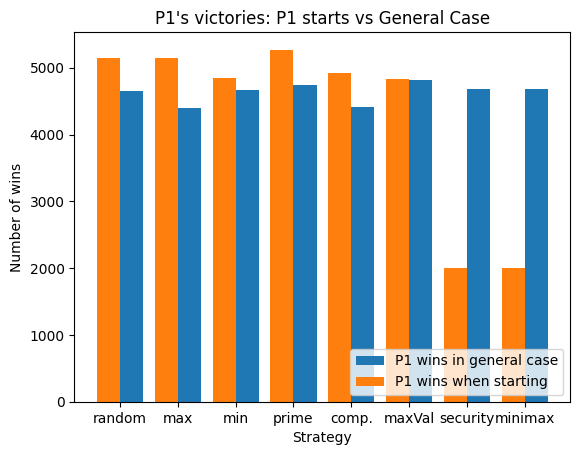

In [ ]:
pl1_wins = [results_matrix[i][i][0] for i in range(len(results_matrix))]
pl1_starting_wins = [results_1_starts_matrix[i][i][0] for i in range(len(results_1_starts_matrix))]

X_axis = np.arange(len(labels))

plt.bar(X_axis + 0.2, pl1_wins, width=0.4,  label='P1 wins in general case')
plt.bar(X_axis - 0.2, pl1_starting_wins, width=0.4, label='P1 wins when starting')

plt.xticks(range(8), ["random", "max", "min", "prime", "comp.", "maxVal", "security", "minimax"])
plt.xlabel("Strategy")
plt.ylabel("Number of wins")
plt.title("P1's victories: P1 starts vs General Case")
plt.legend(loc="lower right")

plt.savefig("Comparison between same strategy for player 1 when he starts vs general case")

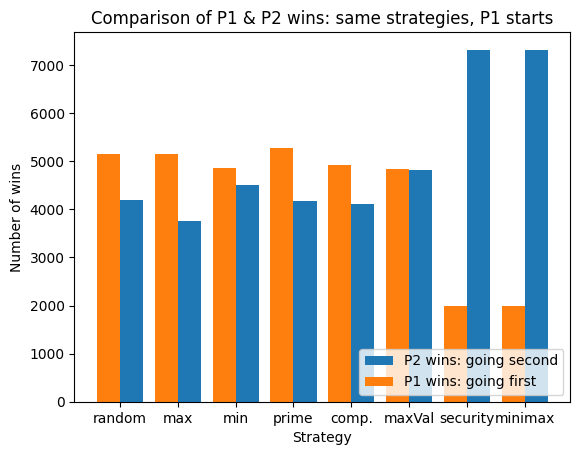

In [ ]:
pl2_wins_1_starting = [results_1_starts_matrix[i][i][1] for i in range(n_strats)]
pl1_wins_1_starting = [results_1_starts_matrix[i][i][0] for i in range(n_strats)]

X_axis = np.arange(len(labels))

plt.bar(X_axis + 0.2, pl2_wins_1_starting, width=0.4,  label='P2 wins: going second')
plt.bar(X_axis - 0.2, pl1_wins_1_starting, width=0.4, label='P1 wins: going first')

plt.xticks(range(8), ["random", "max", "min", "prime", "comp.", "maxVal", "security", "minimax"])
plt.xlabel("Strategy")
plt.ylabel("Number of wins")
plt.title("Comparison of P1 & P2 wins: same strategies, P1 starts")
plt.legend(loc="lower right")

plt.savefig("Comparison on same strategy for both players when player 1 starts")

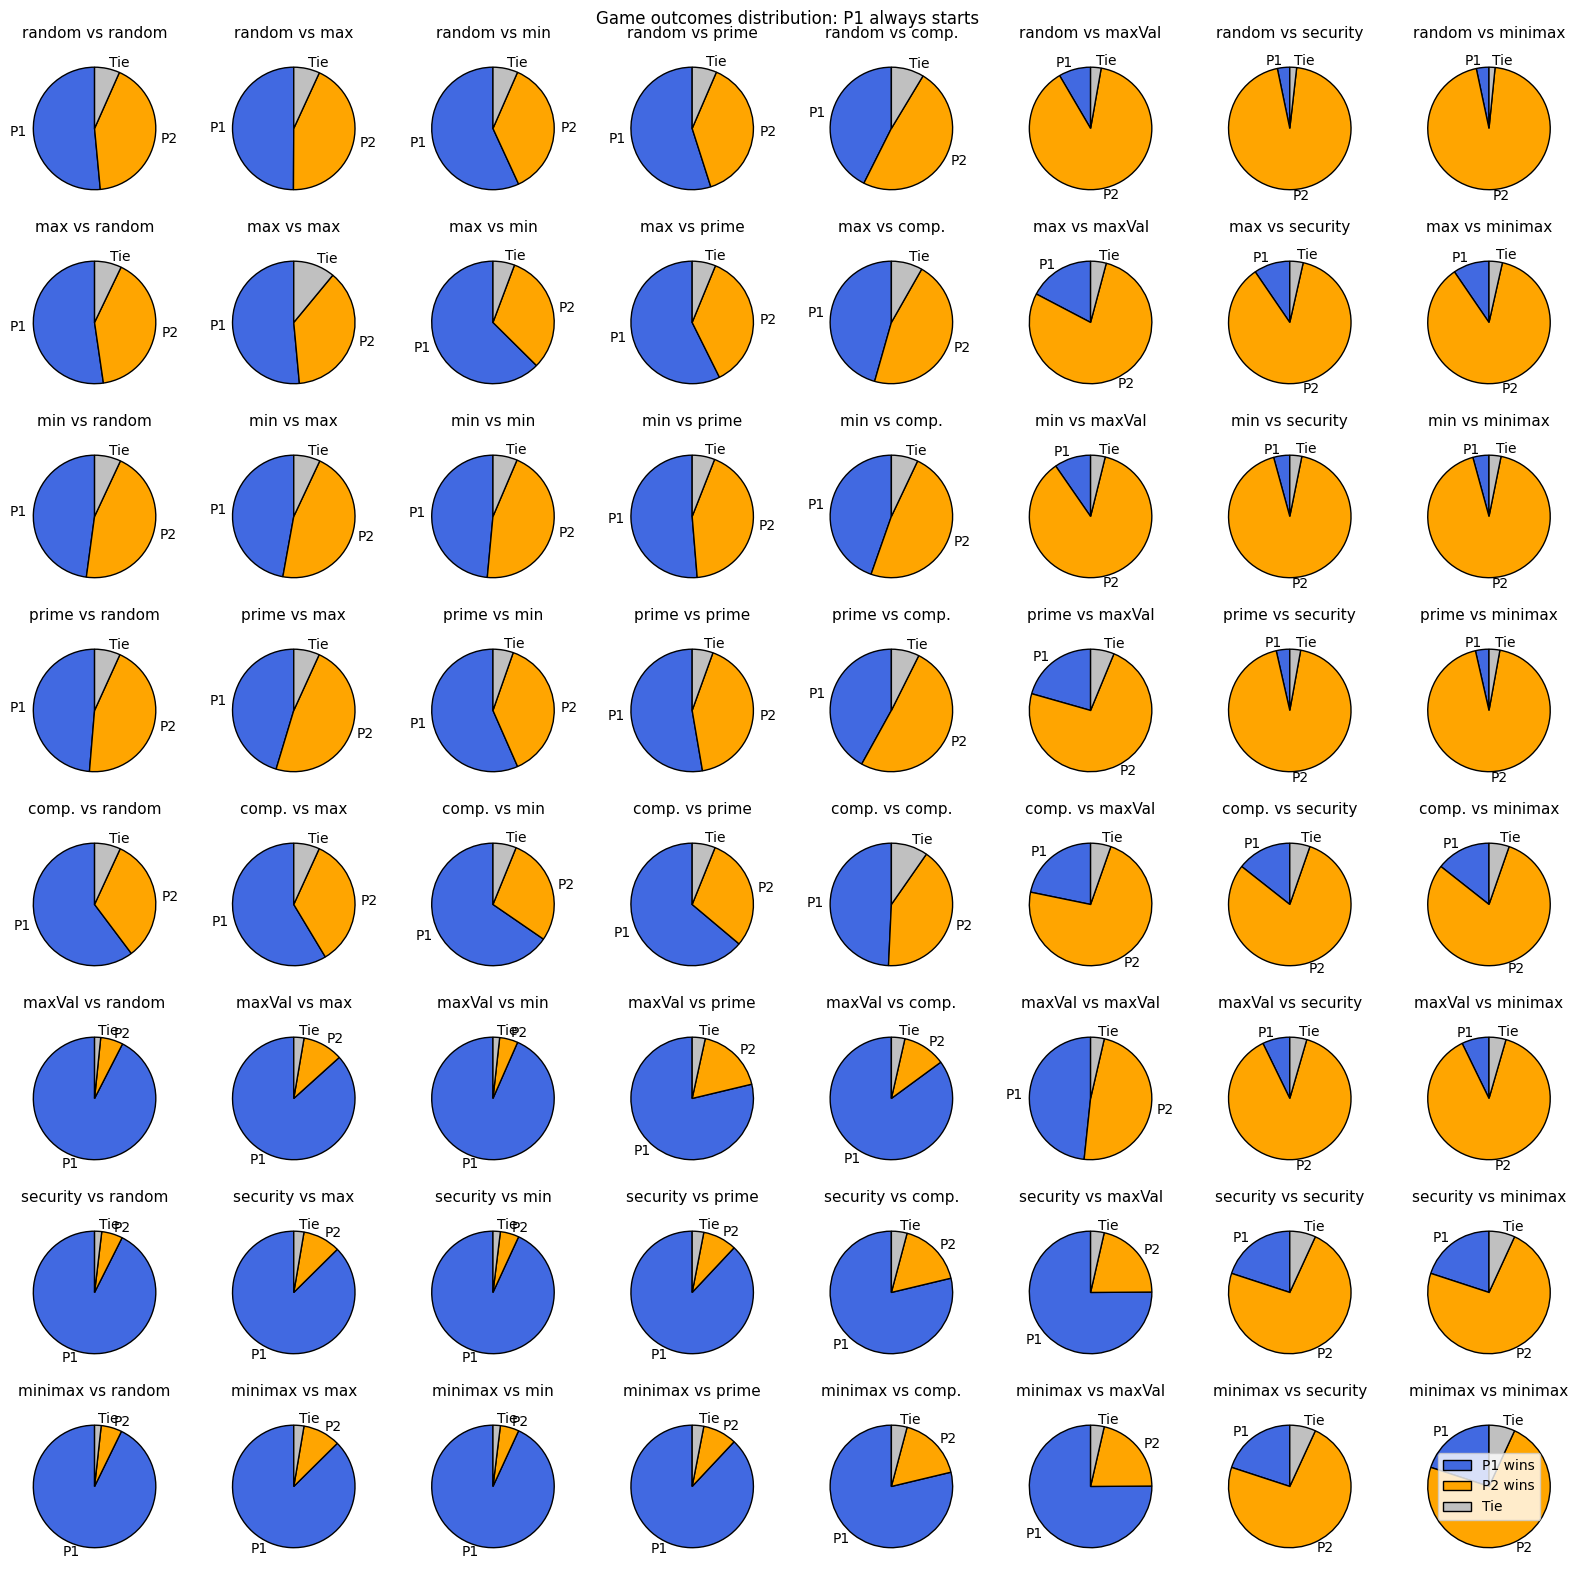

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))

fig.suptitle("Game outcomes distribution: P1 always starts")

for i in range(0,8):
  for j in range(0,8):
    data = [results_1_starts_matrix[i][j][0], results_1_starts_matrix[i][j][1]]
    data.append(n - sum(data))
    axs[i, j].pie(
        data,
        labels=["P1", "P2", "Tie"],
        colors = ["royalblue", "orange", "silver"],
        startangle=90,
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})
    axs[i, j].set_title(short_labels[i] + " vs " + short_labels[j], fontsize=11, pad = 10)

plt.legend(labels=["P1 wins", "P2 wins", "Tie"])
plt.tight_layout()

plt.savefig("Outcomes distribution: P1 starts")

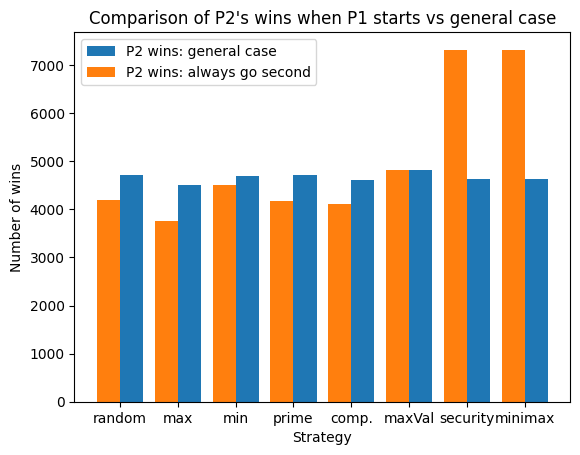

In [ ]:
pl2_wins_general = [results_matrix[i][i][1] for i in range(len(results_matrix))]
pl2_wins_1_starts = [results_1_starts_matrix[i][i][1] for i in range(len(results_1_starts_matrix))]

X_axis = np.arange(len(labels))

plt.bar(X_axis + 0.2, pl2_wins_general, width=0.4,  label='P2 wins: general case')
plt.bar(X_axis - 0.2, pl2_wins_1_starts, width=0.4, label='P2 wins: always go second')

plt.xticks(range(8), ["random", "max", "min", "prime", "comp.", "maxVal", "security", "minimax"])
plt.xlabel("Strategy")
plt.ylabel("Number of wins")
plt.title("Comparison of P2's wins when P1 starts vs general case")
plt.legend()

plt.savefig("Comparison between wins in general vs wins not starting")

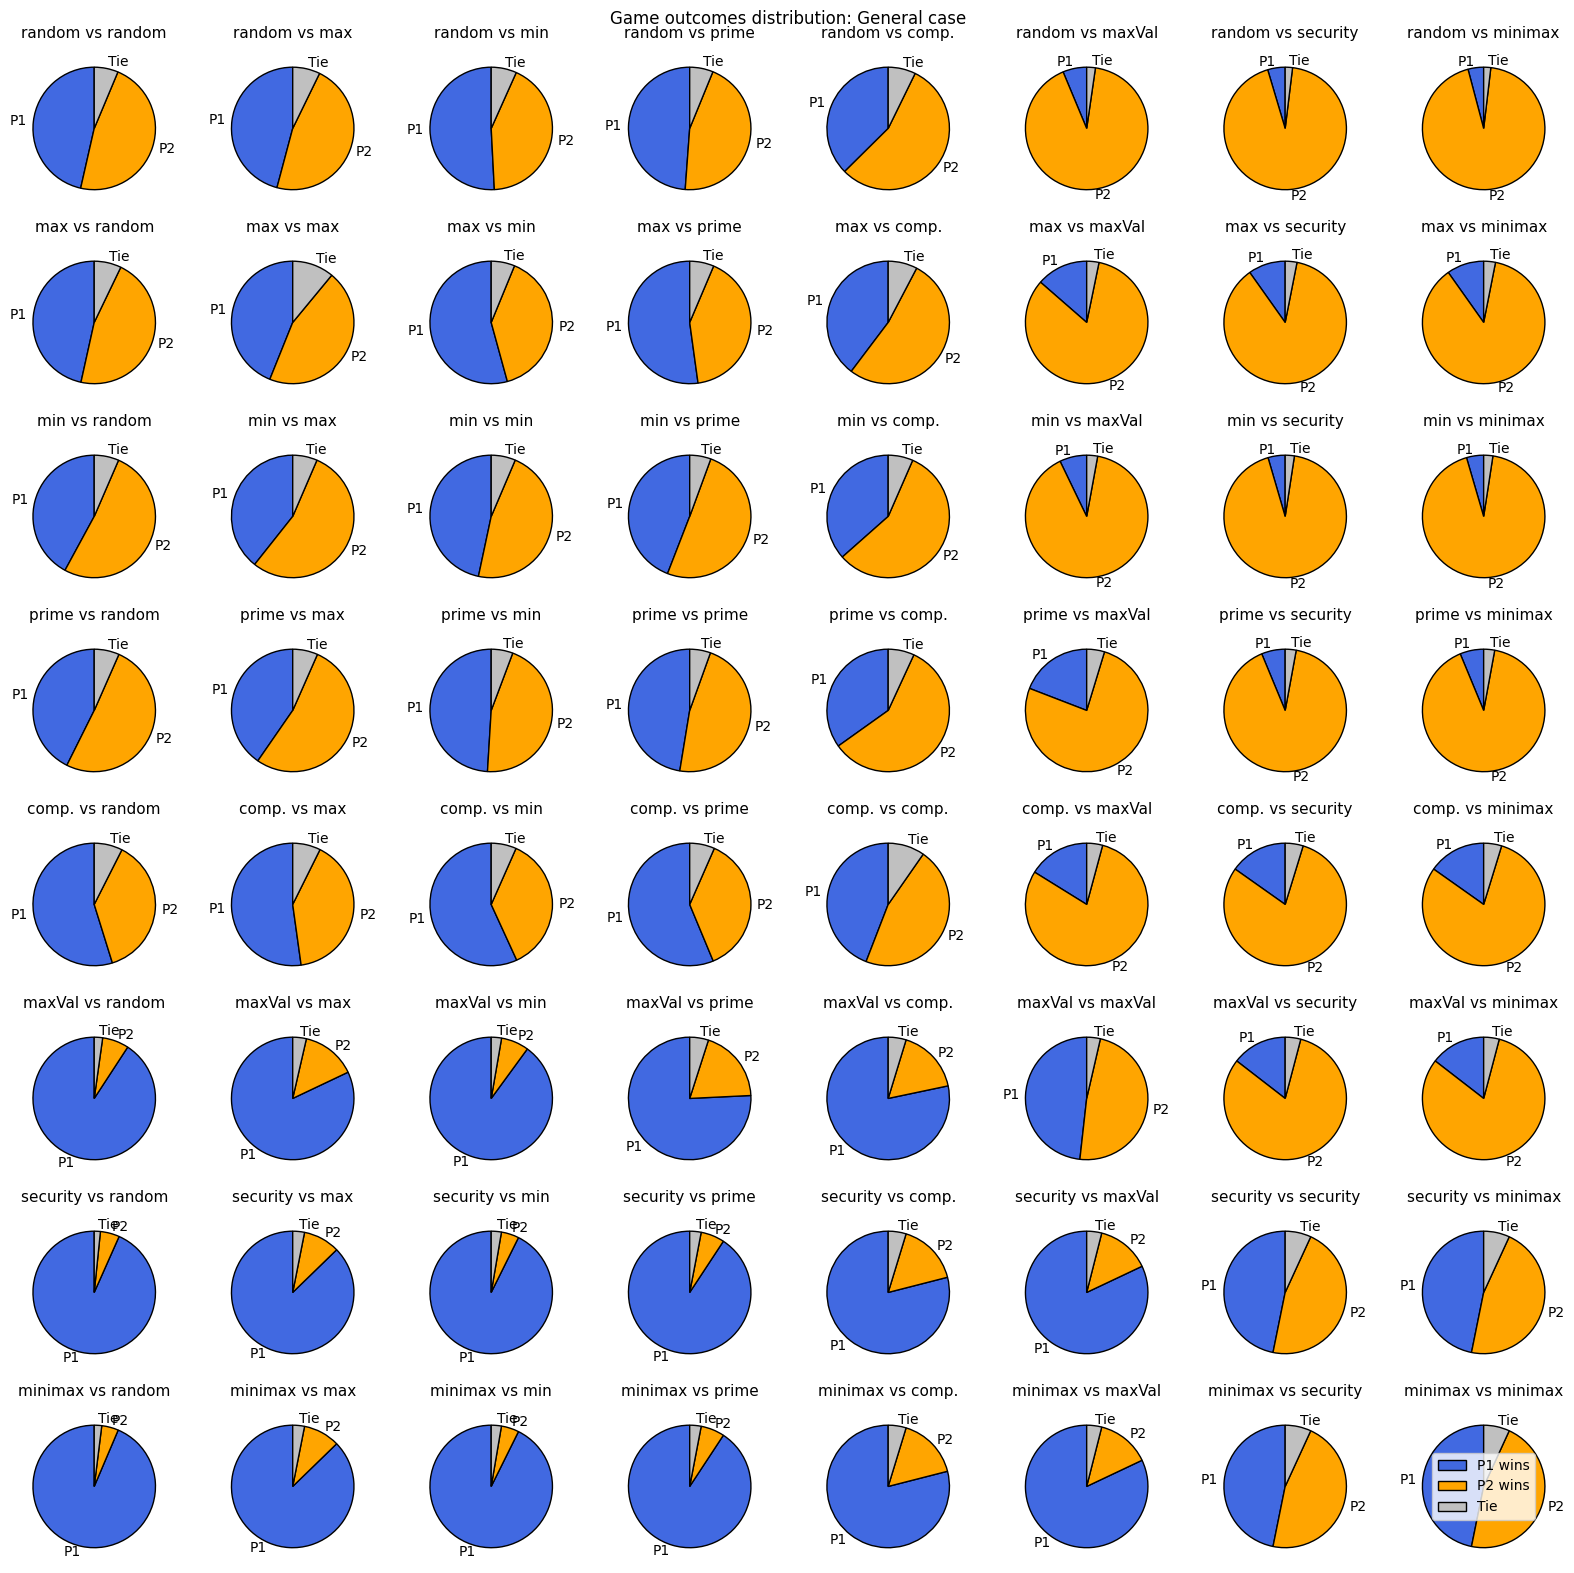

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))

fig.suptitle("Game outcomes distribution: General case")

for i in range(0,8):
  for j in range(0,8):
    data = [results_matrix[i][j][0], results_matrix[i][j][1]]
    data.append(n - sum(data))
    axs[i, j].pie(
        data,
        labels=["P1", "P2", "Tie"],
        colors = ["royalblue", "orange", "silver"],
        startangle=90,
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})
    axs[i, j].set_title(short_labels[i] + " vs " + short_labels[j], fontsize=11, pad = 10)

plt.legend(labels=["P1 wins", "P2 wins", "Tie"])
plt.tight_layout()

plt.savefig("Outcomes distribution: General case")

Box plot in the general case

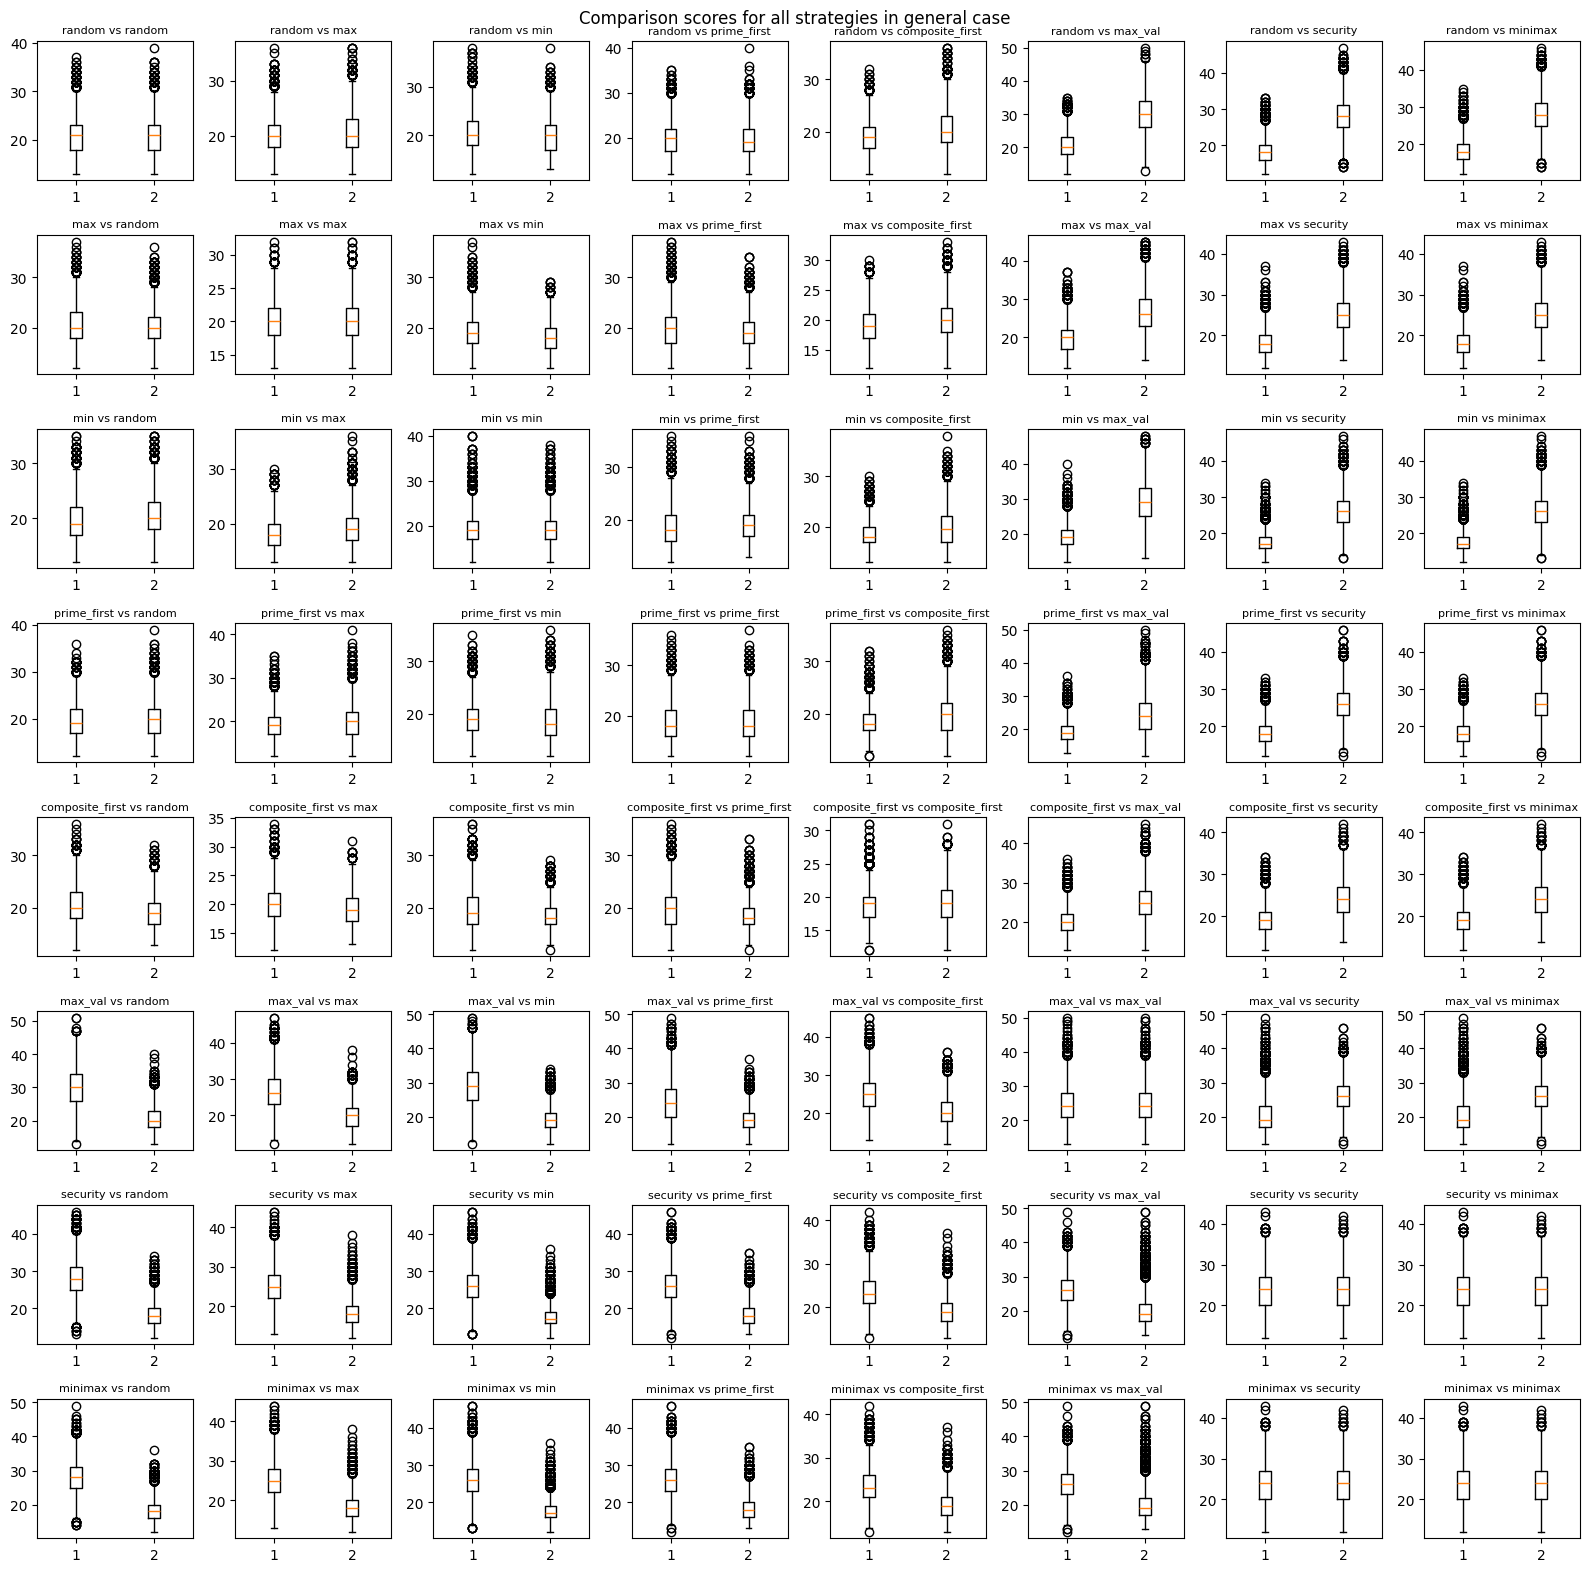

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))

fig.suptitle("Comparison scores for all strategies in general case")

for i in range(0,8):
  for j in range(0,8):
    axs[i, j].boxplot(scores_matrix[i][j])
    axs[i, j].set_title(labels[i] + " vs " + labels[j], fontsize=8)

plt.tight_layout()

plt.savefig("Scores for all strategy pairs: general case")

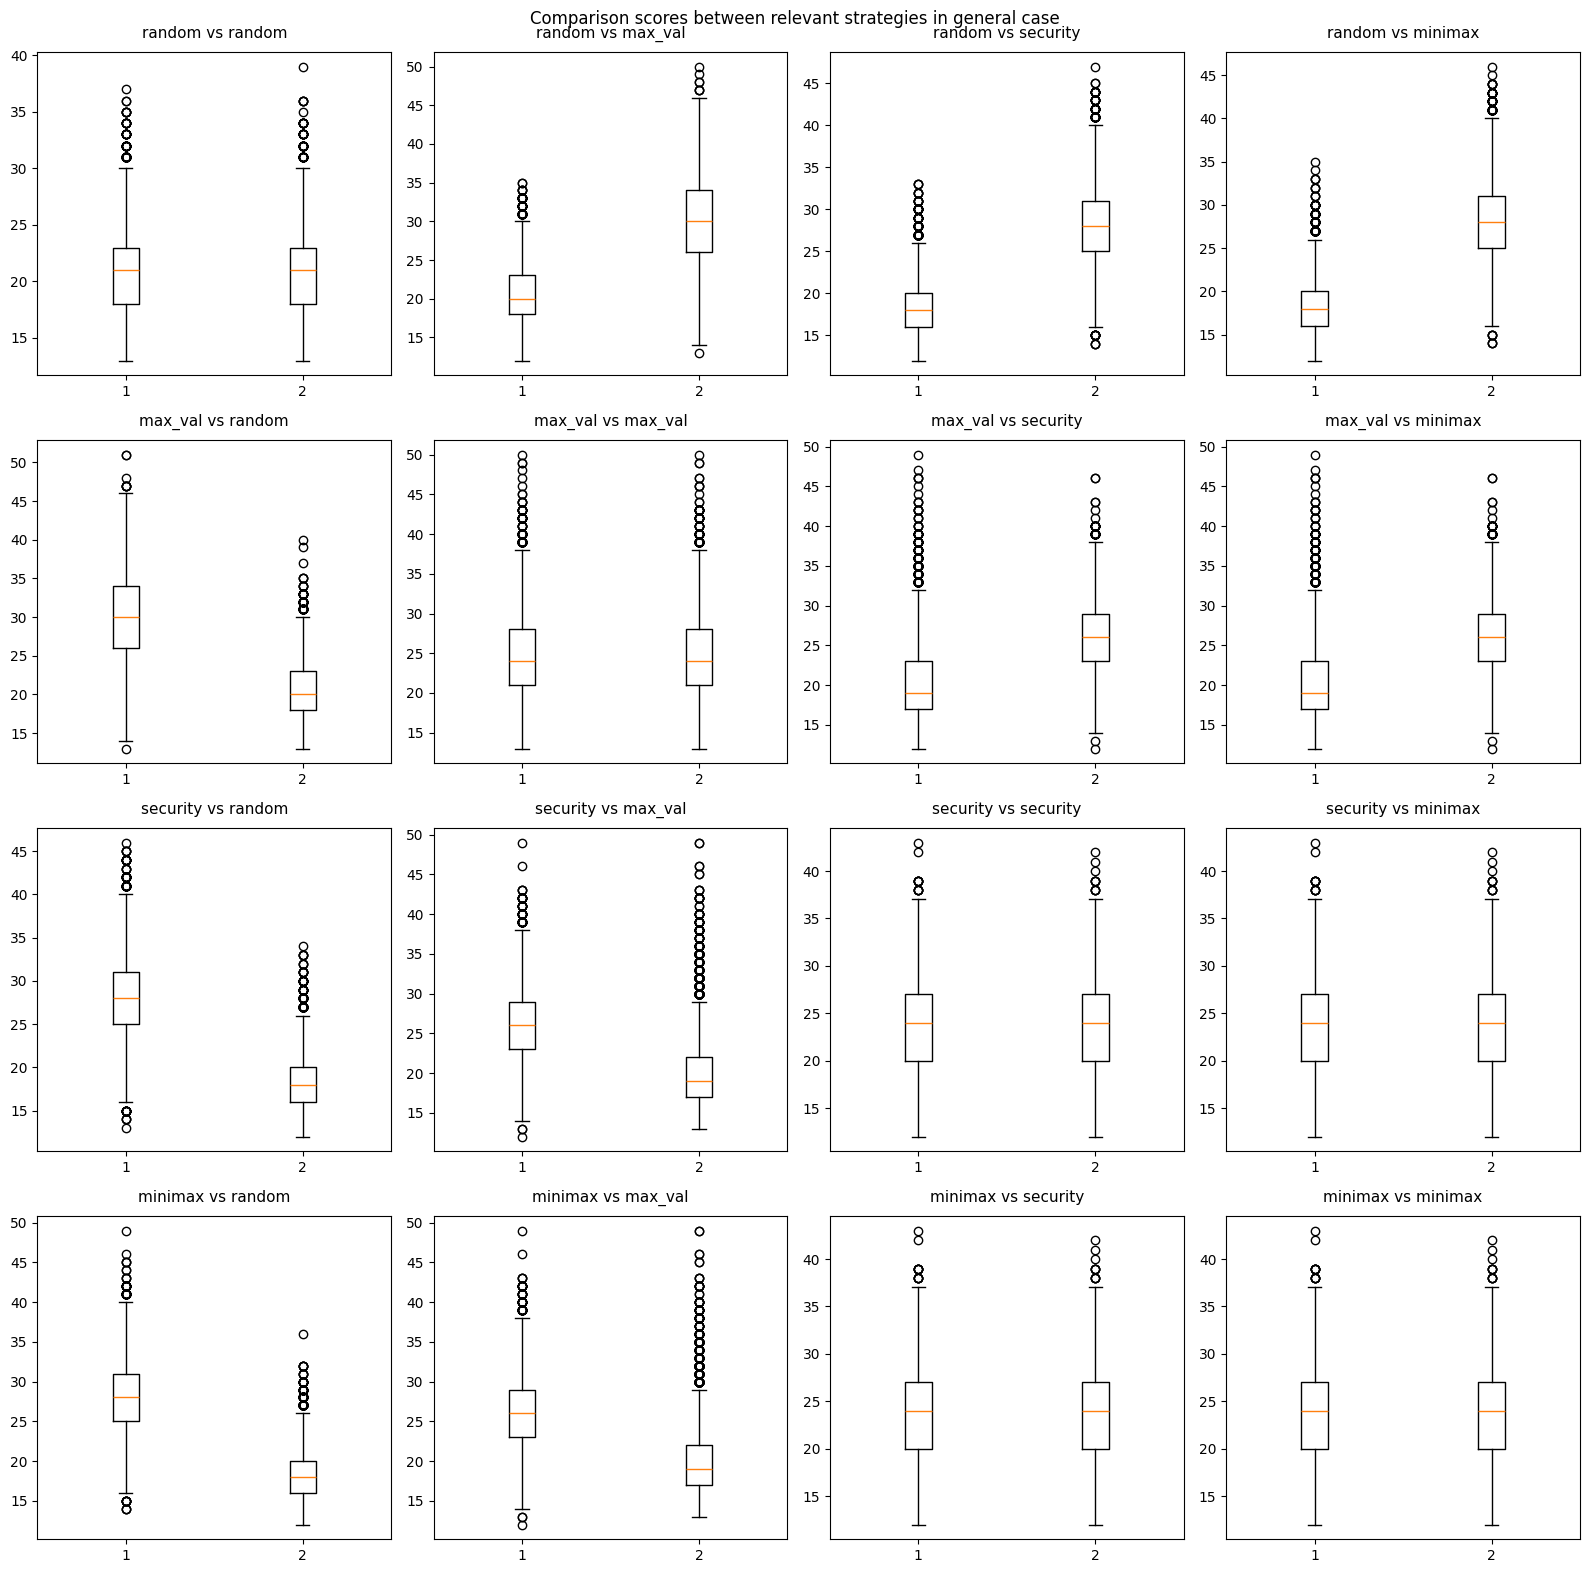

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

fig.suptitle("Comparison scores between relevant strategies in general case")

ind_list = [0, 5, 6, 7]

for i in range(0,4):
  for j in range(0,4):
    axs[i, j].boxplot(scores_matrix[ind_list[i]][ind_list[j]])
    axs[i, j].set_title(labels[ind_list[i]] + " vs " + labels[ind_list[j]], fontsize=11, pad=10)

plt.tight_layout()

plt.savefig("Scores for relevant strategy pairs: general case")

Box plot when player 1 starts

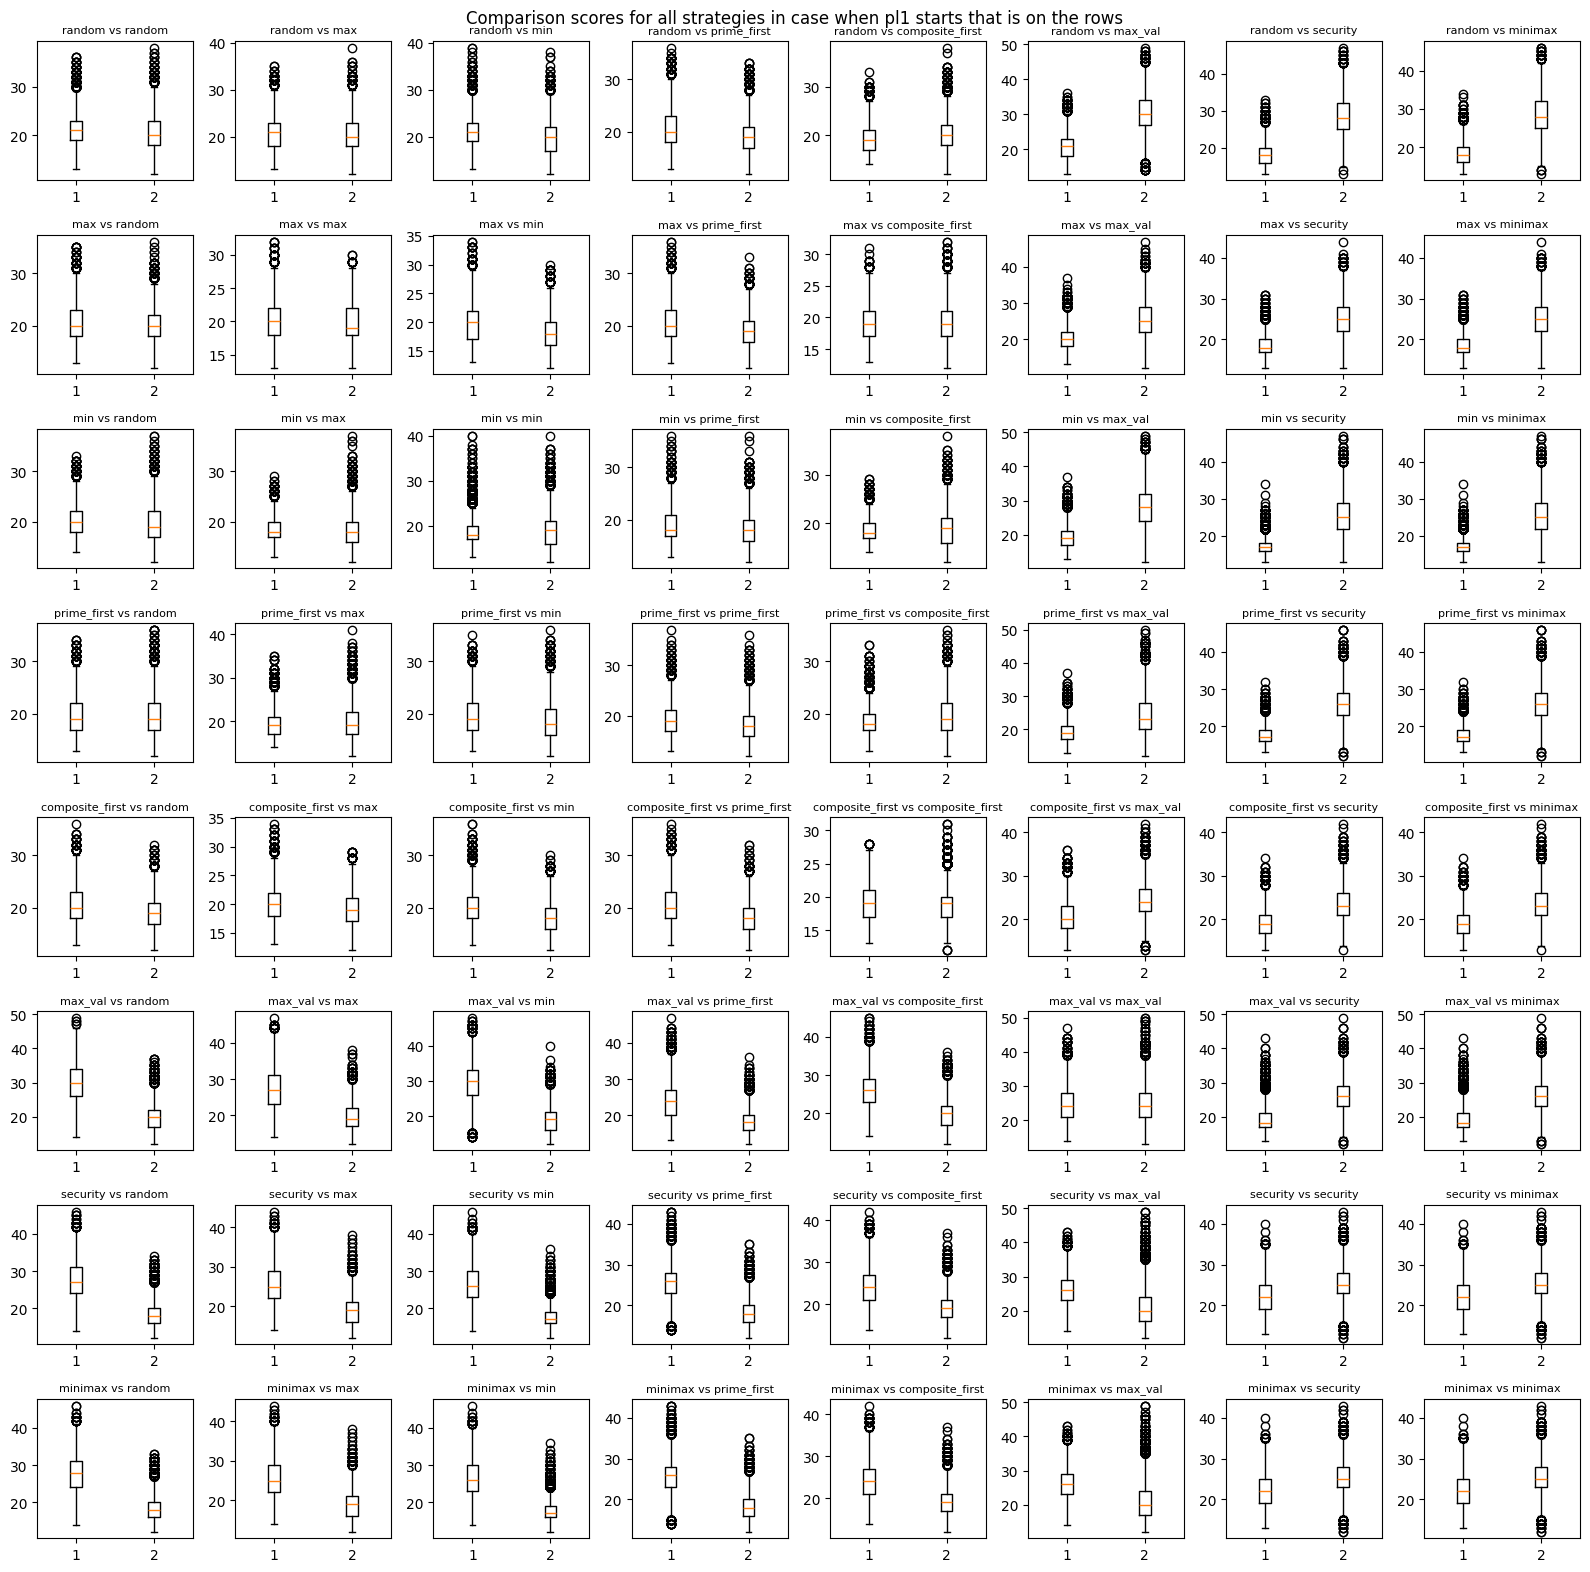

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))

fig.suptitle("Comparison scores for all strategies in case when pl1 starts that is on the rows")

for i in range(0,8):
  for j in range(0,8):
    axs[i, j].boxplot(scores_matrix_1_starts[i][j])
    axs[i, j].set_title(labels[i] + " vs " + labels[j], fontsize=8)

plt.tight_layout()

plt.savefig("Scores for all strategy pairs: P1 starts")

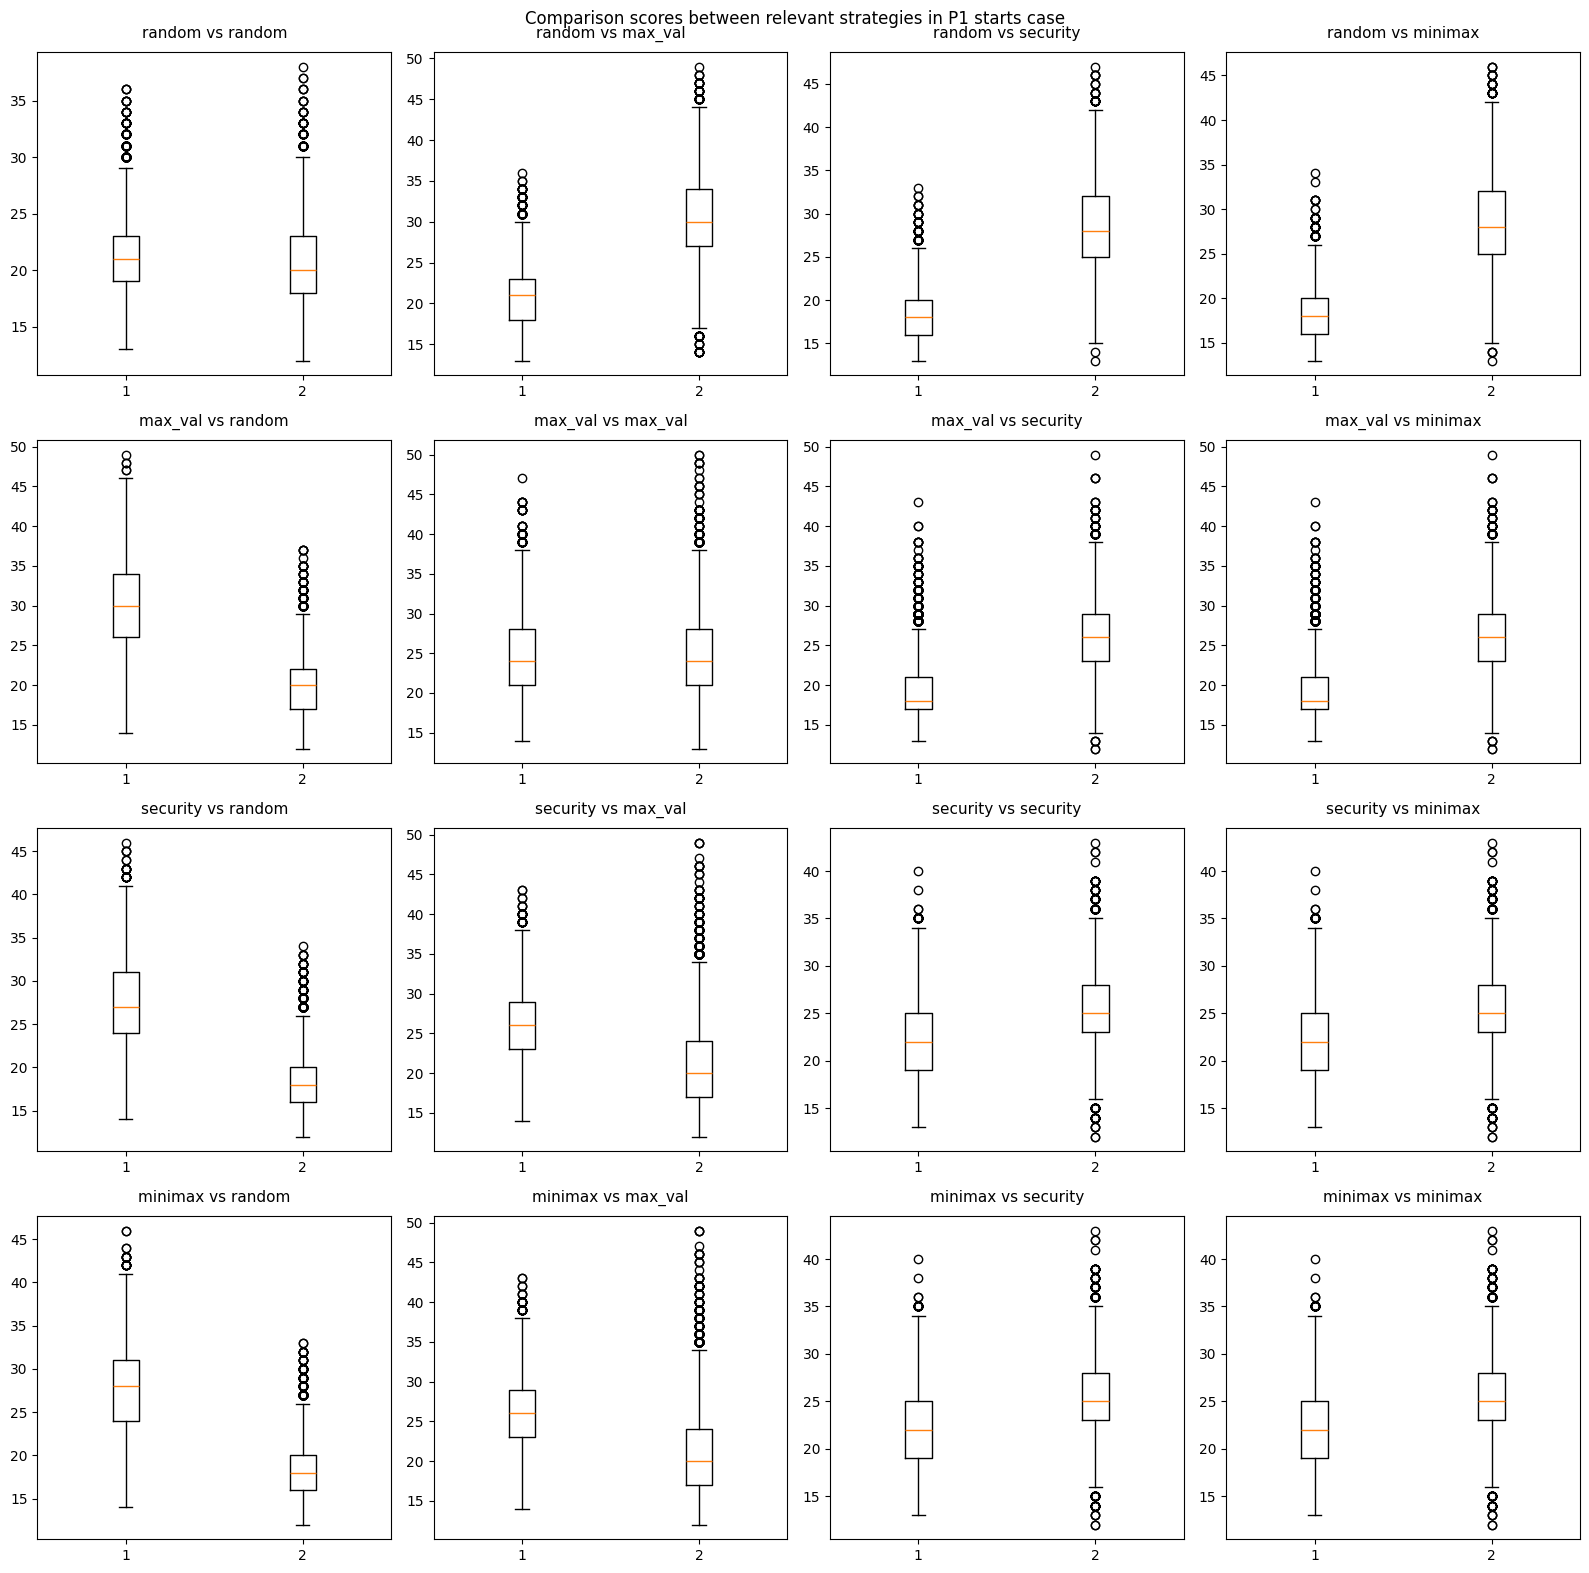

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

fig.suptitle("Comparison scores between relevant strategies in P1 starts case")

ind_list = [0, 5, 6, 7]

for i in range(0,4):
  for j in range(0,4):
    axs[i, j].boxplot(scores_matrix_1_starts[ind_list[i]][ind_list[j]])
    axs[i, j].set_title(labels[ind_list[i]] + " vs " + labels[ind_list[j]], fontsize=11, pad=10)

plt.tight_layout()

plt.savefig("Scores for relevant strategy pairs: P1 starts")

# Probabilties

Probability of winning for player 1 in the general case

In [ ]:
probability_winning_1 = np.zeros(shape=(8,8))

for i in range(len(results_matrix)):
  for j in range(len(results_matrix[i])):
    probability_winning_1[i][j] = np.round(results_matrix[i][j][0] * 100 / (results_matrix[i][j][0] + results_matrix[i][j][1]), 2)

print(probability_winning_1)

[[49.58 49.43 54.47 52.05 40.35  6.44  4.7   4.2 ]
 [50.11 49.33 57.85 55.74 43.02 14.04 10.12 10.12]
 [45.02 42.05 49.86 46.73 39.09  7.36  4.63  4.63]
 [45.65 43.23 52.   50.17 37.44 20.08  6.44  6.44]
 [59.22 56.34 60.88 60.24 48.86 16.88 15.97 15.97]
 [92.85 85.11 92.48 79.72 82.18 50.03 15.14 15.14]
 [94.88 90.06 95.21 93.56 82.9  85.4  50.26 50.26]
 [95.48 90.06 95.21 93.56 82.9  85.4  50.26 50.26]]


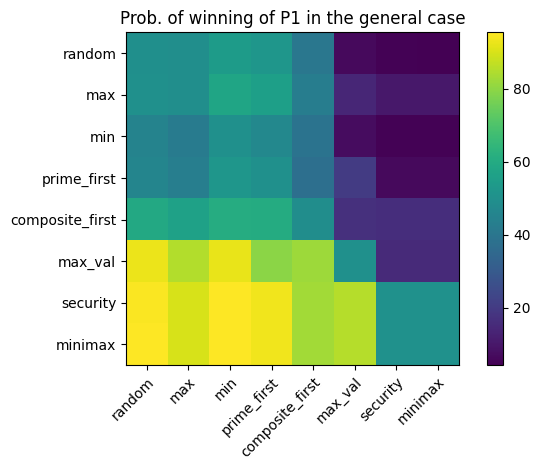

In [ ]:
fig, axs = plt.subplots(1)
fig.subplots_adjust(top=0.8)

cax = axs.matshow(probability_winning_1, interpolation='nearest')
axs.set_title("Prob. of winning of P1 in the general case")
axs.set_xticks(np.arange(8))
axs.set_yticks(np.arange(8))
axs.set_xticklabels(labels)
axs.set_yticklabels(labels)
axs.xaxis.set_label_position('bottom')
axs.xaxis.tick_bottom()
plt.setp(axs.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(cax)

plt.tight_layout()

plt.savefig("Probability of winning of P1 in the general case")

Probability of winning for player 1 when 1 starts

In [ ]:
probability_winning_1_starts = np.zeros(shape=(8,8))

for i in range(len(results_1_starts_matrix)):
  strategy_prob = []
  for j in range(len(results_1_starts_matrix[i])):
    probability_winning_1_starts[i][j] = np.round(results_1_starts_matrix[i][j][0] * 100 / (results_1_starts_matrix[i][j][0] + results_1_starts_matrix[i][j][1]),2)

print(probability_winning_1_starts)

[[55.16 53.59 60.86 58.72 46.62  8.68  3.32  3.38]
 [56.32 57.82 66.37 61.14 49.68 18.07  9.89  9.89]
 [51.43 50.68 51.84 54.56 48.   10.03  4.39  4.39]
 [52.21 48.66 59.8  55.77 45.3  21.96  3.66  3.66]
 [64.69 62.9  69.71 68.01 54.53 23.02 15.18 15.18]
 [93.97 89.08 95.08 81.54 88.21 50.12  7.56  7.56]
 [94.35 89.83 94.97 90.78 82.13 77.89 21.43 21.43]
 [94.41 89.83 94.97 90.78 82.13 77.89 21.43 21.43]]


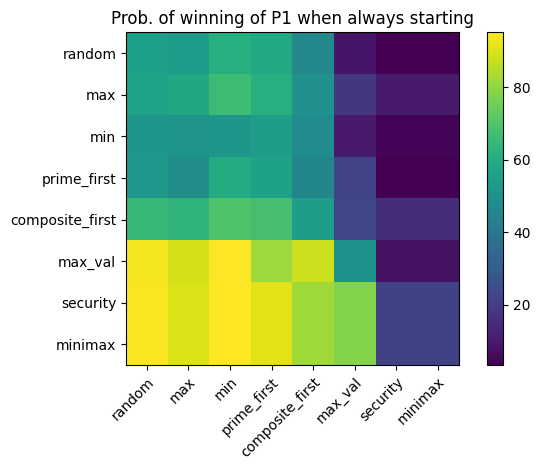

In [ ]:
fig, axs = plt.subplots(1)
fig.subplots_adjust(top=0.8)

cax = axs.matshow(probability_winning_1_starts, interpolation='nearest')
axs.set_title("Prob. of winning of P1 when always starting")
axs.set_xticks(np.arange(8))
axs.set_yticks(np.arange(8))
axs.set_xticklabels(labels)
axs.set_yticklabels(labels)
axs.xaxis.set_label_position('bottom')
axs.xaxis.tick_bottom()

plt.setp(axs.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(cax)

plt.tight_layout()

plt.savefig("Probability of winning of P1 when he starts the game")

Difference between the two sets of probability

In [ ]:
difference_prob = probability_winning_1_starts - probability_winning_1
print(difference_prob)

[[  5.58   4.16   6.39   6.67   6.27   2.24  -1.38  -0.82]
 [  6.21   8.49   8.52   5.4    6.66   4.03  -0.23  -0.23]
 [  6.41   8.63   1.98   7.83   8.91   2.67  -0.24  -0.24]
 [  6.56   5.43   7.8    5.6    7.86   1.88  -2.78  -2.78]
 [  5.47   6.56   8.83   7.77   5.67   6.14  -0.79  -0.79]
 [  1.12   3.97   2.6    1.82   6.03   0.09  -7.58  -7.58]
 [ -0.53  -0.23  -0.24  -2.78  -0.77  -7.51 -28.83 -28.83]
 [ -1.07  -0.23  -0.24  -2.78  -0.77  -7.51 -28.83 -28.83]]


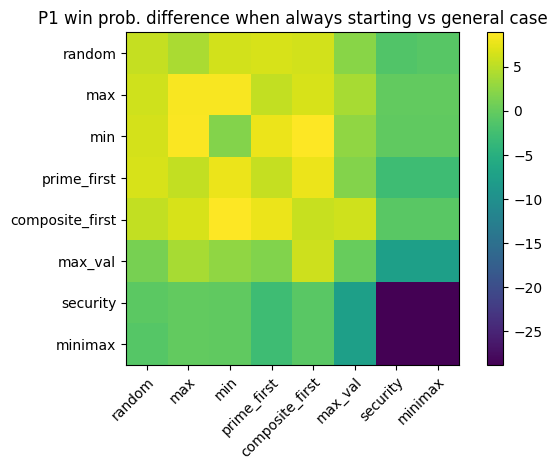

In [ ]:
fig, axs = plt.subplots(1)
fig.subplots_adjust(top=0.8)

cax = axs.matshow(difference_prob, interpolation='nearest')
axs.set_title("P1 win prob. difference when always starting vs general case")
axs.set_xticks(np.arange(8))
axs.set_yticks(np.arange(8))
axs.set_xticklabels(labels)
axs.set_yticklabels(labels)
axs.xaxis.set_label_position('bottom')
axs.xaxis.tick_bottom()

plt.setp(axs.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(cax)

plt.tight_layout()

plt.savefig("Difference between probability of winning for first moving player in the case when he starts the game and general case")

# MLE

In [ ]:
n = samples

In [ ]:
successes = np.zeros(shape=(8, 8))
for i in range(len(results_1_starts_matrix)):
  for j in range(len(results_1_starts_matrix[i])):
    successes[i][j] = results_1_starts_matrix[i][j][0]

def binomial_log_likelihood(p, successes, n):
    p = np.clip(p, 1e-5, 1 - 1e-5)
    ll = np.sum(successes * np.log(p) + (n - successes) * np.log(1 - p))
    return -ll

successes_flat = successes.flatten()

p_init = np.full(successes_flat.shape, 0.5)

result = minimize(
    lambda p: binomial_log_likelihood(p, successes_flat, n),
    x0=p_init,
    method='L-BFGS-B',
    bounds=[(1e-5, 1 - 1e-5)] * successes_flat.size
)

p_est_1_starts = np.round(result.x.reshape(successes.shape), 2)

print("Estimated probability:")
print(p_est_1_starts)

Estimated probability:
[[0.52 0.5  0.57 0.55 0.43 0.08 0.03 0.03]
 [0.52 0.51 0.63 0.57 0.46 0.17 0.1  0.1 ]
 [0.48 0.47 0.49 0.51 0.45 0.1  0.04 0.04]
 [0.49 0.45 0.57 0.53 0.42 0.21 0.04 0.04]
 [0.6  0.59 0.65 0.64 0.49 0.22 0.14 0.14]
 [0.92 0.87 0.93 0.79 0.85 0.48 0.07 0.07]
 [0.93 0.87 0.93 0.88 0.79 0.75 0.2  0.2 ]
 [0.93 0.87 0.93 0.88 0.79 0.75 0.2  0.2 ]]


In [ ]:
successes = np.zeros(shape=(8, 8))
for i in range(len(results_matrix)):
  for j in range(len(results_matrix[i])):
    successes[i][j] = results_matrix[i][j][0]

def binomial_log_likelihood(p, successes, n):
    p = np.clip(p, 1e-5, 1 - 1e-5)
    ll = np.sum(successes * np.log(p) + (n - successes) * np.log(1 - p))
    return -ll

successes_flat = successes.flatten()

p_init = np.full(successes_flat.shape, 0.5)

result = minimize(
    lambda p: binomial_log_likelihood(p, successes_flat, n),
    x0=p_init,
    method='L-BFGS-B',
    bounds=[(1e-5, 1 - 1e-5)] * successes_flat.size
)

p_est = np.round(result.x.reshape(successes.shape), 2)

print("Estimated probability:")
print(p_est)

Estimated probability:
[[0.46 0.46 0.51 0.49 0.37 0.06 0.05 0.04]
 [0.47 0.44 0.54 0.52 0.4  0.14 0.1  0.1 ]
 [0.42 0.39 0.47 0.44 0.37 0.07 0.05 0.05]
 [0.43 0.4  0.49 0.47 0.35 0.19 0.06 0.06]
 [0.55 0.52 0.57 0.56 0.44 0.16 0.15 0.15]
 [0.91 0.82 0.9  0.76 0.78 0.48 0.15 0.15]
 [0.93 0.87 0.93 0.91 0.79 0.82 0.47 0.47]
 [0.94 0.87 0.93 0.91 0.79 0.82 0.47 0.47]]


In [ ]:
print(p_est_1_starts - p_est)

[[ 0.06  0.04  0.06  0.06  0.06  0.02 -0.02 -0.01]
 [ 0.05  0.07  0.09  0.05  0.06  0.03  0.    0.  ]
 [ 0.06  0.08  0.02  0.07  0.08  0.03 -0.01 -0.01]
 [ 0.06  0.05  0.08  0.06  0.07  0.02 -0.02 -0.02]
 [ 0.05  0.07  0.08  0.08  0.05  0.06 -0.01 -0.01]
 [ 0.01  0.05  0.03  0.03  0.07  0.   -0.08 -0.08]
 [ 0.    0.    0.   -0.03  0.   -0.07 -0.27 -0.27]
 [-0.01  0.    0.   -0.03  0.   -0.07 -0.27 -0.27]]
